In [3]:
!pip install segmentation-models-pytorch
!pip install --upgrade albumentations
!pip install "opencv-python-headless<4.3"



     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
     |████████████████████████████████| 376 kB 61.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=bfeac8d0b05fd6d883eee0b085439096c9d0990d060d69b48ca8af71ff4f064b
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=443072925616e6d2b16744930a642a9256f09c2e1893012668fd959f4191f593
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 102 kB 16.3 MB/s 
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
 

In [4]:
import glob
import cv2
import numpy as np
import os
 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
 
import albumentations as albu
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 新しいセクション

In [6]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
# データ拡張
def get_training_augmentation():
    IMAGE_SIZE = 256
    train_transform = [
 
        albu.HorizontalFlip(p=0.5),
 
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
 
        albu.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),
 
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
 
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
 
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
 
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [8]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')
 
# 前処理
def get_preprocessing(preprocessing_fn):
    _transform = [
            albu.Lambda(image=preprocessing_fn),
            albu.Lambda(image=to_tensor, mask=to_tensor),
        ]
    return albu.Compose(_transform)

In [9]:
class Dataset(BaseDataset):
    CLASSES = ['background', 'skin']
    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
 
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

 
        self.augmentation = augmentation
        self.preprocessing = preprocessing
 
    def __getitem__(self, i):
 
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # mask
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [mask]

        mask = np.stack(masks, axis=-1).astype('float')

 
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
 
        return image, mask
 
    def __len__(self):
        return len(self.ids)

In [29]:

# モデルを宣言
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['skin']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
DECODER = 'unet'
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
model = model.to("cuda")

In [31]:
train_dir = '/content/drive/MyDrive/seg_dataset/train'
val_dir = '/content/drive/MyDrive/seg_dataset/val'
 
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
 
# データセットを作成
train_dataset = Dataset(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'masks'),
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['skin'],
)
valid_dataset = Dataset(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'masks'),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['skin'],
)
 
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

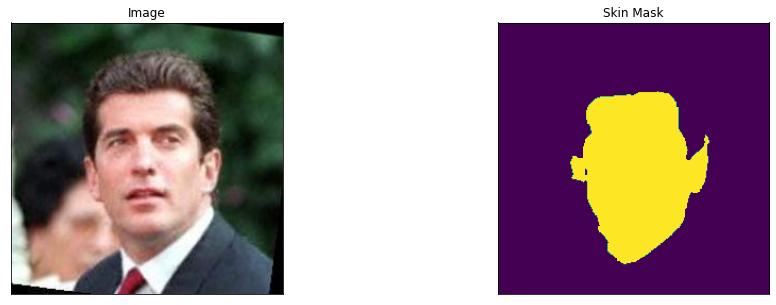

In [32]:
# データ確認
dataset = Dataset(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'masks'), classes=['skin'])
image, mask = dataset[3] # get some sample
visualize(
    image=image, 
    skin_mask=mask.squeeze(),
)

In [33]:
# 精度確認指標
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
# ロス
loss = smp.utils.losses.DiceLoss()
# 最適化関数
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

In [34]:
# 1Epochトレイン用
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [35]:
# 学習 40EPoch 25Epochで学習率を下げる
#テストで3epoch
max_score = 0
for i in range(0, 3):
    
 
    print('\nEpoch: {}'.format(i))
    print(image.shape)
    print(mask.all())
    train_logs = train_epoch.run(train_loader)
    val_logs = valid_epoch.run(valid_loader)

      
 
    # do something (save model, change lr, etc.)
    
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, f'{DECODER}_{ENCODER}.pth')
        print('Model saved!')
 
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')


Epoch: 0
(256, 256, 3)
True
valid: 100%|██████████| 49/49 [00:48<00:00,  1.01it/s, dice_loss - -0.8948, iou_score - 54.28]
Model saved!

Epoch: 1
(256, 256, 3)
True
valid: 100%|██████████| 49/49 [00:02<00:00, 20.16it/s, dice_loss - -0.9316, iou_score - 53.22]

Epoch: 2
(256, 256, 3)
True
valid: 100%|██████████| 49/49 [00:02<00:00, 19.92it/s, dice_loss - -0.9476, iou_score - 54.32]
Model saved!


In [88]:
val_files = glob.glob('/content/drive/MyDrive/seg_dataset/val/images/*')
val_files2 = glob.glob('/content/drive/MyDrive/seg_dataset/val/masks/*')
val_files = sorted(val_files)
val_files2 = sorted(val_files2)
f = val_files[1]
f2 = val_files2[1]

image_src = cv2.imread(f)
image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
ans = cv2.imread(f2)
ans= cv2.cvtColor(ans, cv2.COLOR_BGR2RGB)
# 前処理
image = preprocessing_fn(image_src)
image = image.transpose(2, 0, 1).astype('float32')

# モデルで推論
image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
predict = model(image)
predict = predict.detach().cpu().numpy()[0][0].reshape((256,256))

predict_img = np.zeros([256,256]).astype(np.int8)
predict_img = np.where(predict>0.995, 1 , predict_img)

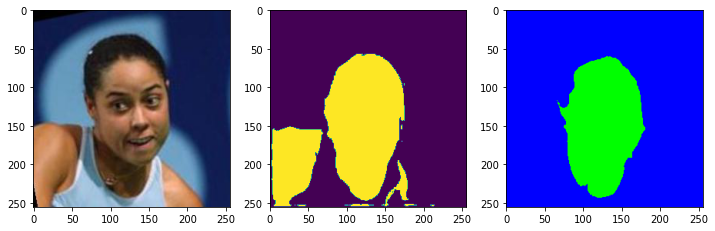

In [89]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1,3,3)
ax1.imshow(image_src)
ax2.imshow(predict_img)
ax3.imshow(ans)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model.pth")